## Compare the average shape of option smiles generated by the Scattering Spectra model to other types of models

Le terme "options smiles" se réfère à la représentation graphique de la volatilité implicite d'options financières en fonction de leur prix d'exercice et de leur échéance. Plutôt que d'avoir une volatilité constante pour toutes les options d'une même échéance, la courbe des "options smiles" montre comment la volatilité implicite varie en fonction du prix d'exercice.

Lorsque la courbe ressemble à un "sourire", avec une volatilité plus élevée pour les options hors de la monnaie (in-the-money et out-of-the-money), cela indique généralement que les participants du marché attribuent une prime plus élevée aux options en raison d'une incertitude accrue pour des mouvements de prix plus importants.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import kurtosis, skew, norm, expon

#import aiohttp

In [2]:
import os
from pathlib import Path
import torch
import warnings

warnings.filterwarnings("ignore")

In [3]:
from scatspectra import PriceData, MRWGenerator
from shadowing import (
    Softmax,
    compute_smile,
    PathShadowing,
    Foveal,
    RelativeMSE,
    PredictionContext,
    ArrayType,
)

from shadowing.utils import windows

CACHE_PATH = Path(os.getcwd()) / "_cache"  # replace with your own cache path


def _torch(x: ArrayType) -> torch.Tensor:
    """Convert x to a torch float tensor."""
    if isinstance(x, torch.Tensor):
        return x
    return torch.tensor(x, dtype=torch.float32)

## Scaterring spectra model

Ce modèle peut être utilisé avec des séries chronologiques comportant des incréments stationnaires. Appliquons sur les données réelles de l'indice S&P 500.

In [4]:
#Commençons par télécharger ces données depuis yahoo finance
# Télécharger les données de S&P 500
ticker = "^GSPC"
start_date = "2000-01-01"
end_date = "2024-01-01"
x_snp = yf.download(ticker, start=start_date, end=end_date).dropna()

[*********************100%%**********************]  1 of 1 completed


In [6]:
x_snp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [17]:
#L'Evolution du prix au fil du temps

plt.figure(figsize=(10, 6))
plt.plot(x_snp["Adj Close"], label = "S&P 500")
plt.title('S&P 500')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

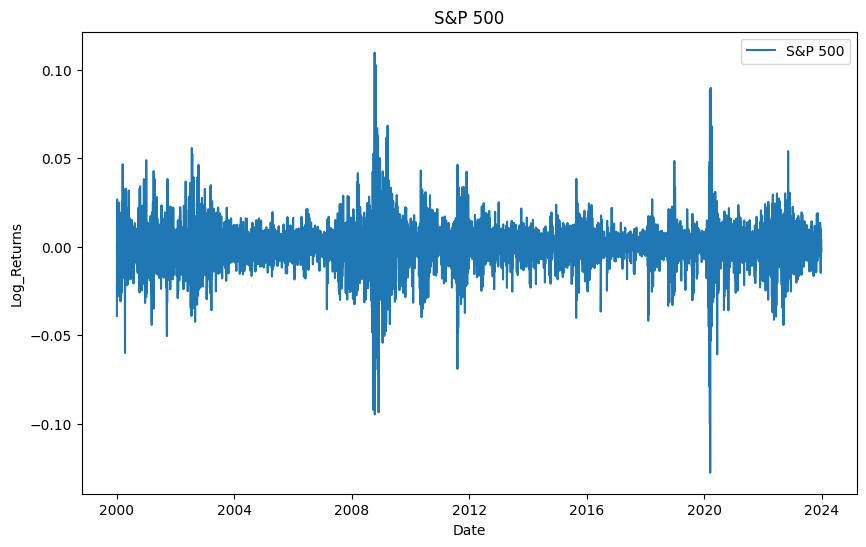

In [18]:
# Calculer les log-rendements de S&P
x_snp['Log_Returns'] = np.log(x_snp['Close'] / x_snp['Close'].shift(1))

plt.figure(figsize=(10, 6))
plt.plot(x_snp['Log_Returns'], label = "S&P 500")
plt.title('S&P 500')
plt.xlabel('Date')
plt.ylabel('Log_Returns')
plt.legend()
plt.show()

In [ ]:
#convertir en données numpy pour la suite des calculs
snp_numpy = x_snp.to_numpy()
snp_numpy

Dans ce qui suit, on va utiliser le même procéder que ce qu'ils ont fait dans le dossier shadowing fichier tutorial (La partie Option Pricing), nous allons juste modifier les contenues des fonctions et les adapter selon notre situation.

In [13]:
# create synthetic dataset
#R = 2048
#lnx_mrw = MRWGenerator(T=4096 + 1, H=0.5, lam=0.2, cache_path=CACHE_PATH).load(R=R)


#Au lieu d'utiliser son MRWGenerator ci-dessus pour le data, nous on va utiliser les données de s&p numpy
lnx_mrw = snp_numpy
dlnx_mrw = np.diff(lnx_mrw, axis=-1)
print("Dataset shape (nb_long_time_series, nb_channels, nb_times): ", dlnx_mrw.shape)
fig, axes = plt.subplots(3, 1, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.plot(dlnx_mrw[i, 0, :], color="black", linewidth=0.5)
    ax.axhline(0.0, color="black", linewidth=0.25)
    ax.set_ylim(-0.03, 0.03)


Dataset shape (nb_long_time_series, nb_channels, nb_times):  (6037, 5)


Problème non ? nos données sont en 2D alors que lui il a travaillé avec les données en 3D. Pourquoi ? Je ne sais pas encore comment m'y prendre avec cette erreur.

In [ ]:
# observed data e.g. past time-series at different dates
# replace with the data you want to predict the future of
#lnx_context = MRWGenerator(T=252 + 1, H=0.5, lam=0.2).load(R=1)


#Une fois encore on va pas utiliser son générateur de données ci-dessus, 
#car lui même il a preciser qu'on peut utiliser les données qu'on veut predire
lnx_context = snp_numpy
dlnx_context = np.diff(lnx_context, axis=-1)
dlnx_context = windows(dlnx_context, w=126, s=32)[0, 0, :, None, :]
print("Context shape (nb_dates, nb_channels, nb_times): ", dlnx_context.shape)
plt.figure(figsize=(15, 1))
plt.plot(np.arange(-126 + 1, 1), dlnx_context[1, 0, :], color="black", linewidth=1.0)
plt.axhline(0.0, color="black", linewidth=0.25)

Encore un autre problème non "negative dimensions are not allowed" ? Je n'ai également aucune idée!

Dans cette cellule ci-dessous, on voit bien les fonctions qu'on a besoin d'appeler mais qui dévraient utiliser les données ci-dessus.

In [ ]:
# embedding for dimensionality reduction
embedding = Foveal(
    alpha=1.15,  # cover the past at exponential speed
    beta=0.9,  # look with a weight power-law decay of 0.9
    max_context=126,  # look at half-year in the observed past
)

# distance between embedded paths
distance = RelativeMSE()

# object for path shadowing
obj = PathShadowing(
    embedding=embedding,
    distance=distance,
    dataset=dlnx_mrw,
    context=PredictionContext(horizon=252),  # the size of such paths in the future
)

# PERFORM PATH SHADOWING
distances, close_paths = obj.shadow(
    dlnx_context,
    k=8192,  # the number of closest paths (from generated dataset) to retain
    n_splits=8,
    cuda=False,  # set to True, if GPU available, for accelarations
)

### Smile at a given date

In [ ]:
Ts = np.array([7, 25, 75])  # maturities in days
Ms = np.linspace(-2.0, 2.0, 9)  # rescaled log-moneyness
r = 0.00  # interest rate

In [ ]:
i_date = 0

context_size = dlnx_context.shape[-1]  # nb of days in the past

# averaging operator in Hedged HMC
ave = Softmax(distances[i_date, :], eta=0.075)

# the shadowing paths extending the currently observed past
x = PriceData(dlnx=close_paths[i_date, :, 0, context_size:], x_init=100.0).x

# HMC on such shadowing paths
smile_conditional = compute_smile(x, Ts, Ms, r, ave)

# plotting
_, ax = plt.subplots(1, 1, figsize=(3, 2))
smile_conditional.plot(ax=ax, color="coral", rescale=True)
ax.set_ylim(0.0, 0.6)

### Average Smile

In [ ]:
# snippets of MRW price trajectories
lnx_mrw_snippets = windows(lnx_mrw[0, 0, :], w=252, s=1)
x = PriceData(lnx=lnx_mrw_snippets, x_init=100.0).x

# HMC on such snippets
smile_avg = compute_smile(x, Ts, Ms, r, ave=None)

# plotting
_, ax = plt.subplots(1, 1, figsize=(3, 2))
smile_avg.plot(ax=ax, color="lightskyblue", rescale=True)
ax.set_ylim(0.0, 0.6)